In [6]:
!git clone https://github.com/mediamead/oneroid.git
!cd oneroid && git checkout master3

Cloning into 'oneroid'...
remote: Enumerating objects: 1375, done.
remote: Counting objects: 100% (1375/1375), done.
remote: Compressing objects: 100% (649/649), done.
remote: Total 1375 (delta 752), reused 1324 (delta 701), pack-reused 0
Receiving objects: 100% (1375/1375), 21.15 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (752/752), done.
Branch 'master3' set up to track remote branch 'master3' from 'origin'.
Switched to a new branch 'master3'


In [16]:
import os, sys
from os.path import dirname
sys.path.append(os.path.join(os.getcwd(), 'oneroid'))

In [11]:
!pip install pybullet

     |████████████████████████████████| 95.2MB 58kB/s 


In [23]:

#you can enable the GPU by changing the runtime
import os
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '330'
import pybullet as p
import pybullet_data as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
p.connect(p.DIRECT)
#allow to find the assets (URDF, obj, textures etc)
p.setAdditionalSearchPath(pd.getDataPath())
#optionally enable GPU for faster rendering in pybullet.getCameraImage
enableGPU = False
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
import sys
# Get all device ids and their processing and memory utiliazion
# (deviceIds, gpuUtil, memUtil) = GPU.getGPUs()

# Print os and python version information
print('OS: ' + sys.platform)
print(sys.version)

# Print package name and version number
print(GPU.__name__ + ' ' + GPU.__version__)

# Show the utilization of all GPUs in a nice table
GPU.showUtilization()

# Show all stats of all GPUs in a nice table
GPU.showUtilization(all=True)

# NOTE: If all your GPUs currently have a memory consumption larger than 1%,
# this step will fail. It's not a bug! It is intended to do so, if it does not
# find an available GPU.
GPUs = GPU.getGPUs()
numGPUs = len(GPU.getGPUs())
print("numGPUs=",numGPUs)
if numGPUs > 0:
  enableGPU = True
eglPluginId = -1
if enableGPU:
  import pkgutil
  egl = pkgutil.get_loader('eglRenderer')
  if (egl):
    eglPluginId = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
  else:
    eglPluginId = p.loadPlugin("eglRendererPlugin")

if eglPluginId>=0:
  print("Using GPU hardware (eglRenderer)")  
else:
  print("using CPU renderer (TinyRenderer)")

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8c39d9fdfab1866fb0e595d43b5f4723a468386deffe8f35fdd2d4dc5ffcba8c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
OS: linux
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
GPUtil 1.4.0
| ID | GPU | MEM |
------------------
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------
numGPUs= 0
using CPU renderer (TinyRenderer)


In [25]:
p.resetSimulation()
p.configureDebugVisualizer(p.COV_ENABLE_GUI)
useFixedBase = True
flags = p.URDF_INITIALIZE_SAT_FEATURES

plane_pos = [0,0,-0.625]
plane = p.loadURDF("plane.urdf", plane_pos, flags = flags, useFixedBase=useFixedBase)
table_pos = [0,0,-0.625]
table = p.loadURDF("table/table.urdf", table_pos, flags = flags, useFixedBase=useFixedBase)
xarm = p.loadURDF("xarm/xarm6_robot.urdf", flags = flags, useFixedBase=useFixedBase)
xarm = p.loadURDF("laikago/laikago_toes.urdf", [1,0,-0.15],[0, 0.5, 0.5, 0], flags = flags, useFixedBase=useFixedBase)


In [24]:
!cd oneroid && git pull && PYTHONPATH=`pwd` && python pyb/mk_cal_images.py

Already up to date.
pybullet build time: Jun 19 2020 04:01:58
*** Initializing PyBulletRobot(ns=4, render=False) ...
*** Initializing PyBulletRobot() done
[0.6981317007977318, -0.39269908169872414, 0.6981317007977318, -0.39269908169872414]
: cannot connect to X server 


In [17]:
from opencv.opencv_pose import Pose
pose = Pose()

TypeError: ignored

In [ ]:
import sys, glob, time
import collections

import numpy as np
import tensorflow as tf
import pandas as pd 

import pybullet as p
from pyb.pybullet_robot import PyBulletRobot

from matplotlib import pyplot as plt
%matplotlib inline

from utils import mk_model, live_plot, plot_fh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
r = PyBulletRobot(4, 4, render=True)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [ ]:
MAX_ALPHA = np.pi/4
D_ALPHA = 0.025

def r_step6(phis):
    phis2 = phis.reshape(-1, 2)
    phis2 = np.append(phis2, [phis2[-1]], axis=0)    
    r.step(phis2)

def set_robot_pose(model, alpha):
    cam_p = [0.23, 0.0, 0.67]
    
    # getQuaternionFromEuler (the roll around the X, pitch around Y and yaw around the Z axis)
    cam_o = r.euler2orn(alpha, np.pi/2, 0)
    cam_v, cam_u = r.orn2vu(cam_o)

    cam_po = np.array(cam_p + cam_o, dtype=np.float32)
    
    phis = model.predict(np.array([cam_po]))[0]
    
    r_step6(phis)
    pvu = r.getHeadcamPVU()

    r.getCameraImage()
    return pvu, cam_po, phis, [cam_p, cam_v, cam_u]

def sweep_model(model):
    cam_pos = list()
    phiss = list()
    
    data_v = collections.defaultdict(list)
    data_u = collections.defaultdict(list)
    data_phis = collections.defaultdict(list)

    for alpha in np.arange(-MAX_ALPHA, MAX_ALPHA+D_ALPHA, D_ALPHA):
        pvu0, cam_po, phis, pvu1 = set_robot_pose(model, alpha)
        cam_pos.append(cam_po)
        phiss.append(phis)

        if True:
            data_v['cam_vx0'].append(pvu0[1][0])
            data_v['cam_vx1'].append(pvu1[1][0])
            data_v['cam_vy0'].append(pvu0[1][1])
            data_v['cam_vy1'].append(pvu1[1][1])
            data_v['cam_vz0'].append(pvu0[1][2])
            data_v['cam_vz1'].append(pvu1[1][2])

        if True:
            data_u['cam_ux0'].append(pvu0[2][0])
            data_u['cam_ux1'].append(pvu1[2][0])
            data_u['cam_uy0'].append(pvu0[2][1])
            data_u['cam_uy1'].append(pvu1[2][1])
            data_u['cam_uz0'].append(pvu0[2][2])
            data_u['cam_uz1'].append(pvu1[2][2])

        if True:
            for i in range(phis.shape[0]):
                data_phis['phi%d' % i].append(phis[i])

    return cam_pos, phiss, data_v, data_u, data_phis

### sweep the head from left to right on a horizontal plane, collect phiss for that trajectory

In [ ]:
model = tf.keras.models.load_model('pose2phis-128-4')
cam_pos, phiss, data_v, data_u, data_phis = sweep_model(model)

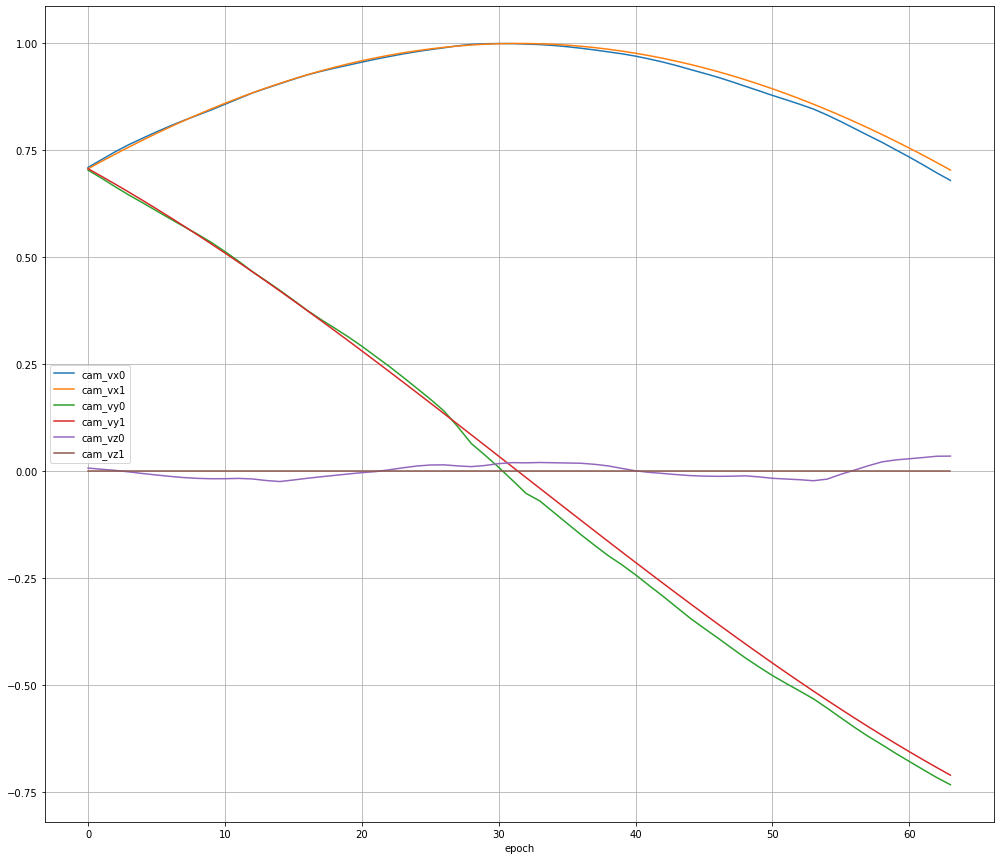

In [ ]:
live_plot(data_v)

### create new batch of phiss based on it, by adding noise

In [ ]:
cam_pos2 = []
phiss2 = []
   
for phis in phiss:
    for i in range(1000):
        if i == 0:
            dphi = 0
        else:
            dphi = np.random.uniform(size=phis.shape[0])*0.001
        phis2 = phis + dphi

        r_step6(phis2)
        cam_p, cam_o = r.getHeadcamPO()
        cam_pos2.append(cam_p + cam_o)
        
        phiss2.append(phis2)
        break

cam_pos2 = np.array(cam_pos2)
phiss2 = np.array(phiss2)
cam_pos2.shape, phiss2.shape

((64, 7), (64, 6))

In [ ]:
#train_data0 = np.load("xy-5000000.npz")
#X = np.vstack(train_data0['X'], cam_pos2)
#Y = np.vstack(train_data0['Y'], phiss2)
X = cam_pos2
Y = phiss2
X.shape, Y.shape

((64, 7), (64, 6))

In [ ]:
phiss = np.array(phiss)
print(phiss[0])
print(Y[0])

[-0.21472406 -0.49184212  0.42276517  0.22187495  0.72451746  0.35383117]
[-0.21472406 -0.49184212  0.42276517  0.22187495  0.72451746  0.35383117]


In [ ]:
model = mk_model()
#fh = model.fit(X, Y, epochs=10, shuffle=True, validation_split=0.002, verbose=1)
fh = model.fit(X, Y, epochs=5000, shuffle=True, verbose=0)

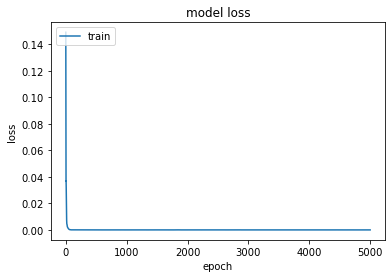

In [ ]:
plot_fh(fh, plot_val_loss=False)

In [ ]:
cam_pos, phiss, data_v, data_u, data_phis = sweep_model(model)

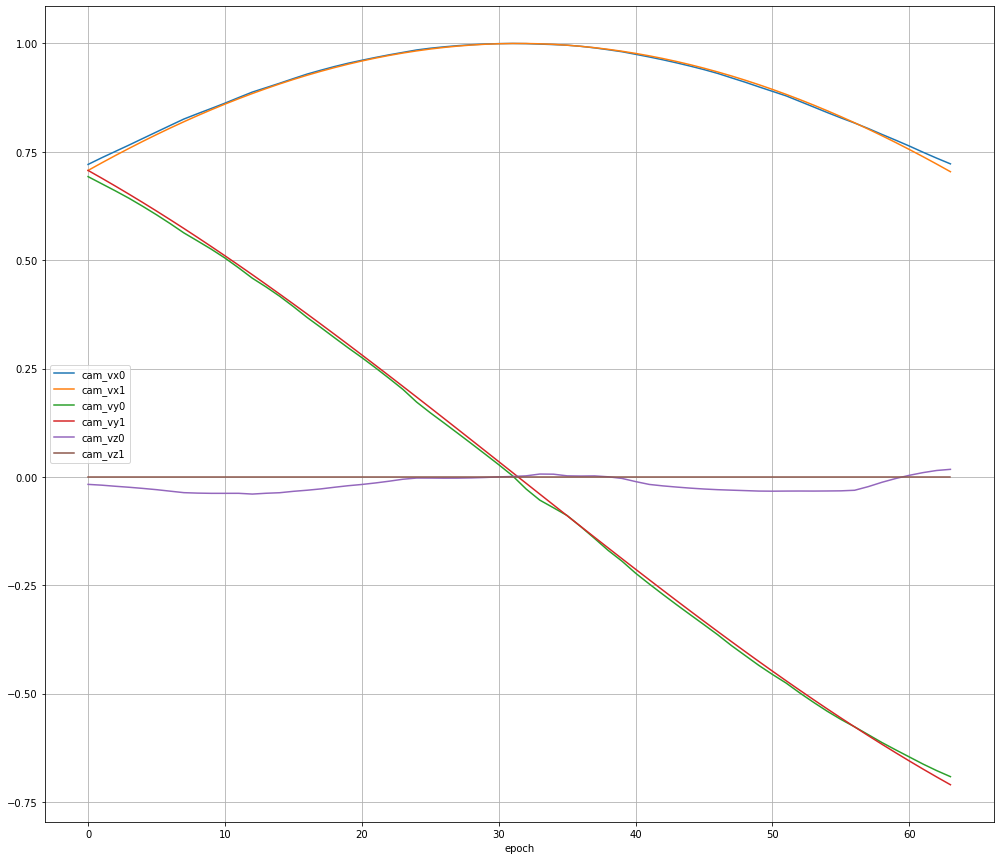

In [ ]:
live_plot(data_v)